# Imports

In [104]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns

## Importar dados

In [58]:
prod = pd.read_excel('dados/produção_pvc.xlsx')
prod.set_index("Ano",inplace=True)
prod = prod.iloc[:10,:]

exp = pd.read_csv('dados/exportação_pvc.csv',sep=';')
exp.columns = ['Ano','SH4','SH4 Description','Exportação (t)']
exp.drop(exp.columns[1:3],inplace=True,axis=1)
exp.set_index('Ano',inplace=True)
exp.sort_values(by='Ano',inplace=True)

imp = pd.read_csv('dados/importação_pvc.csv',sep=';')
imp.columns = ['Ano','SH4','SH4 Description','Importação (t)']
imp.drop(imp.columns[1:3],inplace=True,axis=1)
imp.set_index('Ano',inplace=True)
imp.sort_values(by='Ano',inplace=True)

dados = pd.concat([prod,exp,imp],axis=1)
dados.columns=['PIB (a valores constantes, R$)','Produção (t)','Exportação (t)','Importação (t)']
dados = dados.astype(int)
dados

,"PIB (a valores constantes, R$)",Produção (t),Exportação (t),Importação (t)
Ano,,,,
2007,686463,5634282,59786740,59786740
2008,698661,5921303,37976744,37976744
2009,689488,5913854,52999034,52999034
2010,724926,6359062,13487247,13487247
2011,686491,6611798,13088103,13088103
2012,758588,6738822,13605390,13605390
2013,865671,6941312,13862003,13862003
2014,874308,6976293,14118023,14118023
2015,783455,6728930,82843683,82843683


## Consumo aparente

In [62]:
dados['Consumo Aparente (t)'] = dados[dados.columns[1]] + dados[dados.columns[3]] - dados[dados.columns[2]]
dados.head()

,"PIB (a valores constantes, R$)",Produção (t),Exportação (t),Importação (t),Consumo Aparente (t)
Ano,,,,,
2007,686463,5634282,59786740,59786740,5634282
2008,698661,5921303,37976744,37976744,5921303
2009,689488,5913854,52999034,52999034,5913854
2010,724926,6359062,13487247,13487247,6359062
2011,686491,6611798,13088103,13088103,6611798


## Taxa aritmética e geométrica 
### Para taxa aritmética
\begin{align}
Q_{n} &= Q_o(1+n i_a) \\
i_a &= \left(\frac{Q_n}{Q_o} - 1\right)\frac{1}{n}
\end{align}
### Para taxa geométrica
\begin{align}
Q_n &= Q_o(1+i_g)^n \\
i_g &= \left(\frac{Q_n}{Q_o}\right)^{\frac{1}{n}} - 1
\end{align}

In [73]:
Q_o = dados.loc[2007]['Consumo Aparente (t)']
Q_9 = dados.loc[2016]['Consumo Aparente (t)']
n = 9

i_a = ((Q_9/Q_o) - 1)/n

i_g = (Q_9/Q_o)**(1/n) - 1

## Projeção de tendência

Para regressão linear, temos R2 = 0.66


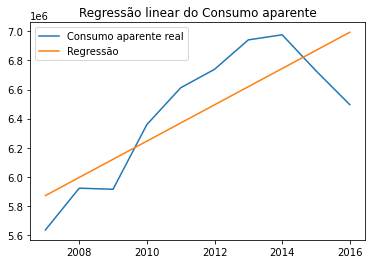

Para regressão exponencial, temos R2 = 0.64


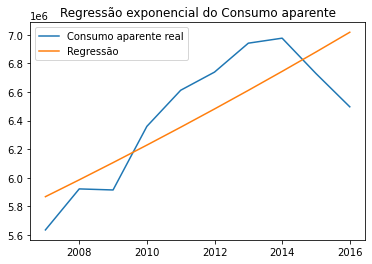

In [271]:
# Regressão linear: y(t) = at+b

x = np.array(dados.index).reshape(len(dados.index),1)
y_lin = np.array(dados['Consumo Aparente (t)']).reshape(len(dados.index),1)
lin_reg = LinearRegression().fit(x, y_lin)

a_lin = lin_reg.coef_[0][0]
b_lin = lin_reg.intercept_[0]

y_pred_lin = a_lin*x+b_lin

r2_lin = r2_score(y_lin,y_pred_lin)
print("Para regressão linear, temos R2 = %.2f"%r2_lin)
plt.title('Regressão linear do Consumo aparente')
plt.plot(dados.index,y_lin,label='Consumo aparente real');
plt.plot(dados.index,y_pred_lin,label='Regressão');
plt.legend()
plt.show()

# Regressão exponencial: y(t)=b*a^t = b*e^(ln(a)*t) => ln(y(t)) = ln(b) + ln(a)*t
x = np.array(dados.index).reshape(len(dados.index),1)
y_exp = np.array(dados['Consumo Aparente (t)']).reshape(len(dados.index),1)
y_exp = np.log(y_exp)
exp_reg =  LinearRegression().fit(x, y_exp)

ln_a = exp_reg.coef_[0][0]
ln_b = exp_reg.intercept_[0]

# lny_pred = ln_b + ln_a*x
# y_pred = np.exp(lny_pred.ravel().astype(float))

a_exp = np.exp(ln_a)
b_exp = np.exp(ln_b)

y_pred_exp = b_exp*a_exp**x

r2_exp = r2_score(np.exp(y_exp),y_pred_exp)
print("Para regressão exponencial, temos R2 = %.2f"%r2_exp)
plt.title('Regressão exponencial do Consumo aparente')
plt.plot(dados.index,np.exp(y_exp),label='Consumo aparente real');
plt.plot(dados.index,y_pred_exp,label='Regressão');
plt.legend()
plt.show();

## CA x PIB

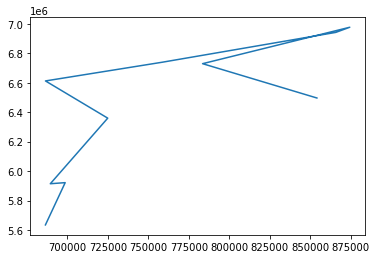

In [294]:
x = np.array(dados[dados.columns[0]]).reshape(len(dados.index),1)
y = np.array(dados[dados.columns[-1]]).reshape(len(dados.index),1)
lin_reg = LinearRegression().fit(x, y_lin)
α = lin_reg.coef_[0,0]
β = lin_reg.intercept_[0]

proj_realista = β + α*x
proj_pessimista = β + α*x/2.0

y_exp = np.array(dados[dados.columns[-1]]).reshape(len(dados.index),1)
y_exp = np.log(y_exp)
exp_reg =  LinearRegression().fit(x, y_exp)

ln_α = exp_reg.coef_[0][0]
ln_β = exp_reg.intercept_[0]

α_exp = np.exp(ln_α)
β_exp = np.exp(ln_β)

proj_otimista = β_exp*α_exp**x

plt.plot(x,dados[dados.columns[-1]],label='Histórico')